#                                       **CIFAR-10: Image Classification**

#   Step 1: Data Preprocessing & Loading 
##  Visualization of Images and Labels / Inserting Grayscale Conversion / Augmentation 


%pip install matplotlib
%pip install numpy
%pip install tensorflow
%pip install tensorflow-gpu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

In [4]:
# Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
# Check data dimensions
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


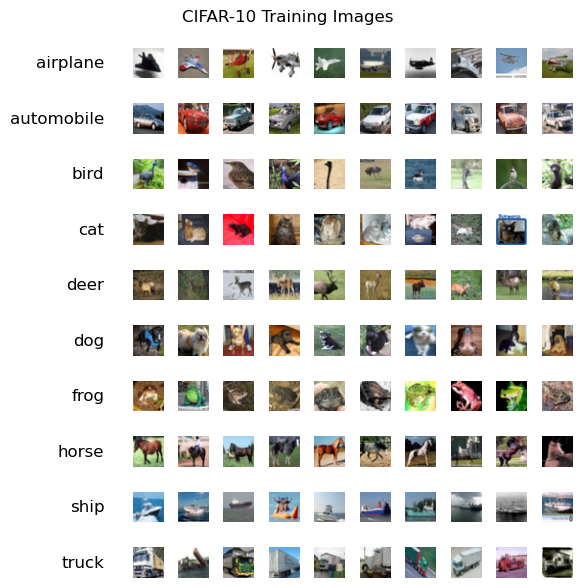

In [6]:
# Define a list with all the class labels for CIFAR-10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to visualize color images from CIFAR-10 dataset with correct labeling
def visualize_color_images_with_labels(images, labels, classes, images_per_class=10, title="CIFAR-10 Images"):
    num_classes = len(classes)
    total_images = num_classes * images_per_class

    plt.figure(figsize=(6, 6))
    image_count = 0

    # Loop through class labels to pick images_per_class images per class
    for class_index, class_name in enumerate(classes):
        class_images = images[labels.flatten() == class_index][:images_per_class]

        # Loop through the images, arranging them dynamically
        for img in class_images:
            plt.subplot(num_classes, images_per_class, image_count + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add class label to the left side of each row
            if image_count % images_per_class == 0:
                plt.text(-30, 32 // 2, class_name, rotation=0, size='large', va='center', ha='right')
            
            image_count += 1
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize color images from the CIFAR-10 training set
visualize_color_images_with_labels(x_train, y_train, classes, images_per_class=10, title="CIFAR-10 Training Images")


# Convert images to grayscale (Not in use because of DenseNet)

grayscale_x_train = tf.image.rgb_to_grayscale(x_train)
grayscale_x_test = tf.image.rgb_to_grayscale(x_test)

gray_x_train = np.array(grayscale_x_train)
gray_x_test = np.array(grayscale_x_test)

print(gray_x_train.shape)
print(gray_x_test.shape)

In [7]:
# Data Augmentation:



# Create augmentation layer for model (used further down)

data_augmentation = Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
]) 


In [8]:
# Normalize the images to the range [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

print(x_train_normalized.shape)
print(x_test_normalized.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [9]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


Task, Diego:
Transfer Traning (VGG-16 can work well, imagenit, inseption, densnet, resnet) Check which one is the most efficient to clasify our image model.
Build a model Densnet
- Research different networks to see what kind of data they were trained on (image classes, how many...?)
- Decide on best one for our dataset
- Think about how many layers to add on top of that for our specific model
- Think about which layers to freeze/ unfreeze when training with the new layers
- Adjust epochs, other parameters related to our new model which could optimize

# DenseNet Model

In [10]:
from keras.applications import DenseNet121

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

In [14]:
# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
# Since pooling='avg' is used, we don't need to add GlobalAveragePooling2D manually
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Freeze the first 119 layers
for layer in base_model.layers[:119]:
    layer.trainable = False
# Unfreeze the top 119 layers of the model
for layer in base_model.layers[119:]:
    layer.trainable = True

# Add a fully connected layer (base model already applies global average pooling)
x = base_model.output
x = Dense(56, activation='relu')(x) # Increased from 128 to 512 neurons Can be remove if not needed, we chnace to 56 density layers for this test
x = Dense(56, activation='relu')(x) # Adding another dense layer before the output

# Output layer for CIFAR-10 (10 classes)
predictions = Dense(10, activation='softmax')(x)

# Final model creation
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model to retain the pre-trained ImageNet weights
#for layer in base_model.layers:
    #layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation (only applied to the images)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    #Added for more Aggressive Data Augmentation (Can be remove if nesessary)
    tf.keras.layers.RandomZoom(0.2),  # Add zoom
    tf.keras.layers.RandomContrast(0.1),  # Add contrast
])

# Apply data augmentation only to the training images, not labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))  # Augment only images
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce the learning rate by half
    patience=3,  # After 3 epochs with no improvement
    min_lr=0.1  # Minimum learning rate
)

# Train the model using the new data pipeline
model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[lr_scheduler]
)


# Make predictions using the model
predictions = model.predict(val_dataset)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 448s 250ms/step - accuracy: 0.3986 - loss: 1.6720 - val_accuracy: 0.5966 - val_loss: 1.1647 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 362s 231ms/step - accuracy: 0.5474 - loss: 1.2689 - val_accuracy: 0.5912 - val_loss: 1.1856 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 389s 249ms/step - accuracy: 0.5816 - loss: 1.1884 - val_accuracy: 0.4366 - val_loss: 1.7130 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 289s 185ms/step - accuracy: 0.5541 - loss: 1.2531 - val_accuracy: 0.5481 - val_loss: 1.3319 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 277s 177ms/step - accuracy: 0.5769 - loss: 1.1888 - val_accuracy: 0.5802 - val_loss: 1.1944 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 272s 174ms/step - accuracy: 0.5782 - loss: 1.1864 - val_accuracy: 0.5631 - val_loss: 1.3468 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 328s 210ms

KeyboardInterrupt: 

#Copy of the model with Layers unfrezee

In [15]:
# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
# Since pooling='avg' is used, we don't need to add GlobalAveragePooling2D manually
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Freeze the first 119 layers
#for layer in base_model.layers[:119]:
    #layer.trainable = False
# Unfreeze the top 119 layers of the model
#for layer in base_model.layers[119:]:
    #layer.trainable = True

# Add a fully connected layer (base model already applies global average pooling)
x = base_model.output
x = Dense(56, activation='relu')(x) # Increased from 128 to 512 neurons Can be remove if not needed
x = Dense(56, activation='relu')(x) # Adding another dense layer before the output

# Output layer for CIFAR-10 (10 classes)
predictions = Dense(10, activation='softmax')(x)

# Final model creation
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model to retain the pre-trained ImageNet weights
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation (only applied to the images)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    #Added for more Aggressive Data Augmentation (Can be remove if nesessary)
    tf.keras.layers.RandomZoom(0.2),  # Add zoom
    tf.keras.layers.RandomContrast(0.1),  # Add contrast
])

# Apply data augmentation only to the training images, not labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))  # Augment only images
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset without augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce the learning rate by half
    patience=3,  # After 3 epochs with no improvement
    min_lr=0.1  # Minimum learning rate
)

# Train the model using the new data pipeline
model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[lr_scheduler]
)


# Make predictions using the model
predictions = model.predict(val_dataset)


Epoch 1/10
1062/1563 ━━━━━━━━━━━━━━━━━━━━ 3:04 368ms/step - accuracy: 0.3585 - loss: 1.7563

KeyboardInterrupt: 

In [ ]:
# Load the pre-trained DenseNet121 model
#base_model = DenseNet121(weights='imagenet', include_top=False)

# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Adding custom Top layers that will be trained for CIFAR-10 classification
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(128, activation='relu')(x)

# Add the output layer
predictions = Dense(10, activation='softmax')(x)

# Create the final model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=20)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train_normalized, y_train, batch_size=32)
val_generator = val_datagen.flow(x_test_normalized, y_test, batch_size=32)

# Train the model
model.fit_generator(train_generator,
                  steps_per_epoch=100,
                  epochs=10,
                  validation_data=val_generator,
                  validation_steps=50)

# Use the model to make predictions
predictions = model.predict(x_test_normalized)


In [ ]:
# Load DenseNet121 with pre-trained ImageNet weights, excluding the top layer
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

# Make the base model non-trainable
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Activation('relu'),
    Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Show model structure
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(x_train)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=len(x_train) / 64, epochs=10,
                    validation_data=(x_test, y_test))


    # Unfreeze the top 50 layers of the model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# It's important to recompile the model after you make any changes to the 'trainable' attribute of any inner layer, so that your changes are taken into account
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, Activation
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator




#  Step 4: Model Evaluation
## Evaluate the Model and Compute Metrics